In [14]:
# %pip install jax

In [136]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
import time
import scipy
from IPython.core.display import HTML
import matplotlib.animation as animation

# import jax.numpy as jnp
# import jax

In [ ]:
# Define initial conditions

r = np.array([[-1, 0], [1, 0], [0, 0]])


r_dot = np.array([[0.080584, 0.588836], [0.080584, 0.588836], [-0.161168, -1.177672]])


time_limit = 21.272338

y = [r, r_dot]

y_flat = np.array(y).flatten()

In [192]:
def acceleration(X: np.ndarray) -> np.ndarray:
    vec_diff = X - X[:, np.newaxis]
    distance_matrix = np.linalg.norm(vec_diff, axis=2) ** 3

    # Set distance 0 to inf to avoid dividing by 0
    distance_matrix[distance_matrix == 0] = np.inf

    acceleration = vec_diff / distance_matrix[:, :, np.newaxis]

    return -np.sum(acceleration, axis=0)


def f_acceleration_flat(x, y_flat):
    # Reshape 0:r,r_dot 1:planets 2:x,y
    y = y_flat.reshape(2, 3, 2)
    return np.array([y[1], acceleration(y[0])]).flatten()


def calculate_y_error(y0, y_end):
    return np.sum((y0-y_end)**2)

def calculate_error_position(trajectory):
    return np.sum(np.abs(trajectory[0] - trajectory[-1]))

methods = ['RK45', 
        #    'RK23', 
           'DOP853', 
        #    'Radau', 
           'BDF', 
           'LSODA']
t_eval = np.linspace(0, time_limit, 500)
mses = []
errors = []
solve_times = []
steps = []
for method in methods:
    start_t = time.time()
    scipy_ivp = scipy.integrate.solve_ivp(
        f_acceleration_flat,
        (0, time_limit),
        y_flat,
        method=method,
        # t_eval=t_eval,
        vectorized=False,
        atol=1e-7,
        rtol=1e-7,
    )
    solve_time = time.time()-start_t

    scipy_ivp_trajectory = scipy_ivp.y.reshape(2, 6, -1)[0].T.reshape(-1, 3, 2)
    scipy_ivp_velocity_trajectory = scipy_ivp.y.reshape(2, 6, -1)[1].T.reshape(-1, 3, 2)

    error_position = calculate_error_position(scipy_ivp_trajectory)
    mse = calculate_y_error(y_flat, scipy_ivp.y[:,-1])

    errors.append(error_position)
    mses.append(mse)
    solve_times.append(solve_time)
    steps.append(scipy_ivp_trajectory.shape[0])
    


In [191]:
print(f"3 Body problem error (Difference of starting and final positions):")
title = f"{'method':<10} | {'mse':<10} | {'abs':<10} | {'time':<10} | steps"
print(title)
print("-"*len(title))
for method, error, mse, solve_time, stepn in zip(methods,errors, mses, solve_times, steps):
    print(f"{method:<10} | {mse:<10.4e} | {error:<10.3e} | {solve_time:<10.3e} | {stepn}")

3 Body problem error (Difference of starting and final positions):
method     | mse        | abs        | time       | steps
---------------------------------------------------------
RK45       | 5.0268e-07 | 8.451e-04  | 5.256e-01  | 500
DOP853     | 1.0014e-06 | 1.167e-03  | 3.394e-01  | 500
BDF        | 2.3186e-05 | 5.552e-03  | 9.214e-01  | 500
LSODA      | 1.9467e-06 | 1.593e-03  | 2.183e-01  | 500


In [193]:
print(f"3 Body problem error (Difference of starting and final positions):")
title = f"{'method':<10} | {'mse':<10} | {'abs':<10} | {'time':<10} | steps"
print(title)
print("-"*len(title))
for method, error, mse, solve_time, stepn in zip(methods,errors, mses, solve_times, steps):
    print(f"{method:<10} | {mse:<10.4e} | {error:<10.3e} | {solve_time:<10.3e} | {stepn}")

3 Body problem error (Difference of starting and final positions):
method     | mse        | abs        | time       | steps
---------------------------------------------------------
RK45       | 5.0268e-07 | 8.451e-04  | 3.412e-01  | 764
DOP853     | 1.0014e-06 | 1.167e-03  | 3.130e-01  | 363
BDF        | 2.3186e-05 | 5.552e-03  | 1.235e+00  | 3356
LSODA      | 1.9467e-06 | 1.593e-03  | 1.713e-01  | 2091


Fixed time steps with t_eval seem to require a longer processing time.

Choosing LSODA since it has a good performance and manages stiffnes 

In [163]:
scipy_ivp = scipy.integrate.solve_ivp(
    f_acceleration_flat,
    (0, time_limit),
    y_flat,
    method="LSODA",
    t_eval=t_eval,
    vectorized=False,
    atol=1e-7,
    rtol=1e-7,
)
solve_time = time.time()-start_t

scipy_ivp_trajectory = scipy_ivp.y.reshape(2, 6, -1)[0].T.reshape(-1, 3, 2)
scipy_ivp_velocity_trajectory = scipy_ivp.y.reshape(2, 6, -1)[1].T.reshape(-1, 3, 2)


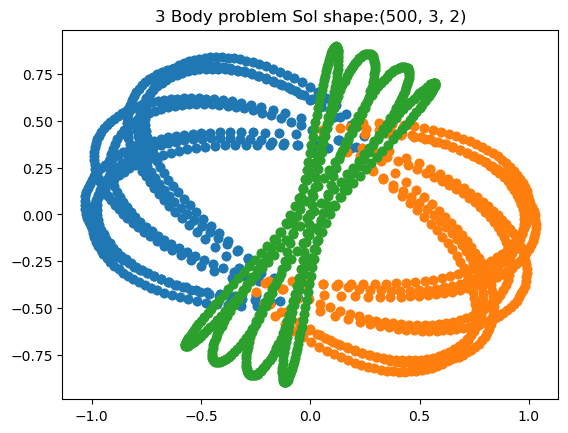

In [164]:
def plot_trajectory(trajectory):
    for i in range(3):
        path = trajectory[:, i, :]
        plt.scatter(path[:, 0], path[:, 1])
        plt.title(f"3 Body problem Sol shape:{scipy_ivp_trajectory.shape}")


indices = np.linspace(0, len(scipy_ivp_trajectory) - 1, num=1_000, dtype=int)
plot_trajectory(scipy_ivp_trajectory[indices])

In [165]:
scipy_ivp_trajectory[ts, 0,:]

array([-0.97937237,  0.07467129])

(-4.0, 4.0)

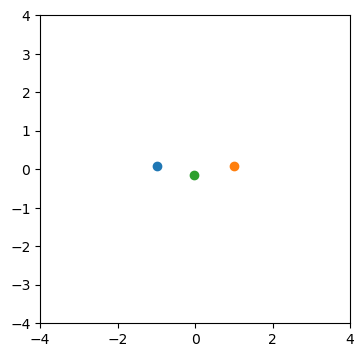

In [ ]:
# Setup animation basis
ts = 3
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
scatters = []
for i in range(3):
    scatters.append(axes.scatter(*scipy_ivp_trajectory[ts, i]))
lims = 4
axes.set_ylim(-lims,lims)
axes.set_xlim(-lims,lims)

In [167]:



def update(frame):
    # print(frame.shape)
    for i in range(3):
        scatters[i].set_offsets(frame[i])
    # frame, t = frame_time
    # for i, prop in enumerate(np.moveaxis(frame, -1, 0)):
    #     # print(i, prop.shape)
    #     ims[i].set_offsets(prop)
    # ax.set_title(f"Frame animation frame:{i}")
    # i+=1


def do_animation(frames, fig, interval):
    ani = animation.FuncAnimation(
        fig=fig, func=update, frames=frames, interval=interval
    )
    # plt.close()
    return ani


def ani_to_html(ani):
    return HTML(ani.to_jshtml())


ani = do_animation(scipy_ivp_trajectory[:, :, :], fig, 60)
ani_to_html(ani)